# Práctica 1 - NNs

### Natalia Martínez García, Lucía Vega Navarrete
### Grupo: AP.11.06

En esta práctica vamos a utilizar el dataset STL-10, que está diseñado para clasificación de imágenes. Vamos a ver que contiene 13,000 imágenes etiquetadas de tamaño 96×96 píxeles en color (RGB), y que estas se clasifican en 10 clases (avión, pájaro, coche, gato, ciervo, perro, caballo, mono, barco, camión). Además incluye 100,000 imágenes sin etiquetar para aprendizaje no supervisado, aunque no las vamos a utilizar. El objetivo es entrenar una red neuronal para clasificar estas imágenes.

Primero cargaremos y preprocesaremos los datos: normalizando las imágenes, convirtiendo las etiquetas a one-hot y aplanando cada imagen en un vector. Después entrenaremos varios modelos cambiando la regularización para intentar mejorar la generalización y evitar sobreajuste.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, models, regularizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

En primer lugar importamos las librerías que vamos a utilizar a lo largo de la práctica.


Fijamos una semilla aleatoria para asegurar que los experimentos sean reproducibles y así poder compararlos mejor. Sin ella, procesos como la inicialización de pesos o el shuffle de datos producirían resultados diferentes en cada ejecución, y no podríamos determinar si las diferencias de rendimiento se deben al azar.

In [2]:
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

### 1. Carga del dataset

In [3]:
# Cargamos el dataset ya dividido en entrenamiento y test
(train, test), info_ds = tfds.load(
    'stl10',
    split=['train', 'test'],
    as_supervised=True,  # devuelve tuplas con la forma (imagen, etiqueta)
    with_info=True # devuelve info extra del dataset (número de clases, tamaño de imagen, etc)
)

num_clases = info_ds.features['label'].num_classes
nombres_clases = info_ds.features['label'].names
tamano_imagen = info_ds.features['image'].shape
dimension_entrada = np.prod(tamano_imagen)

print("\n" + "="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)

print(f"NOMBRE: {info_ds.name}")
print(f"\nIMÁGENES:")
print(f" - Dimensiones: {tamano_imagen}")
print(f" - Tipo: {info_ds.features['image'].numpy_dtype}")
print(f" - Longitud aplanada: {dimension_entrada}")


print(f"\nETIQUETAS:")
print(f" - Número de clases: {num_clases}")
print(f" - Clases: {', '.join(nombres_clases)}")

print(f"\nSPLITS:")
print(f" - Train: {info_ds.splits['train'].num_examples:,} imágenes")
print(f" - Test: {info_ds.splits['test'].num_examples:,} imágenes")
print(f" - Unlabelled: {info_ds.splits['unlabelled'].num_examples:,} imágenes (NO LOS USAMOS)")


INFORMACIÓN DEL DATASET
NOMBRE: stl10

IMÁGENES:
 - Dimensiones: (96, 96, 3)
 - Tipo: <class 'numpy.uint8'>
 - Longitud aplanada: 27648

ETIQUETAS:
 - Número de clases: 10
 - Clases: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

SPLITS:
 - Train: 5,000 imágenes
 - Test: 8,000 imágenes
 - Unlabelled: 100,000 imágenes (NO LOS USAMOS)


### 2. Preprocesado

In [4]:
def preprocesado(imagen, etiqueta):
    imagen = tf.cast(imagen, tf.float32) / 255.0  # imagen a float32 y escala [0,1]
    imagen = tf.reshape(imagen, [-1]) # aplanamos a un vector unidimensional
    etiqueta = tf.one_hot(etiqueta, depth = num_clases) # one-hot encoding
    return imagen, etiqueta

def preprocesado_dataset(dataset):
    # Creamos listas vacías donde almacenaremos las imágenes y etiquetas preprocesadas.
    imagenes = []
    etiquetas = []

    for img, label in dataset: 
        imagen, etiqueta = preprocesado(img, label) # Aplicamos el preprocesado a cada muestra 
        # Añadimos los resultafos a las listas 
        imagenes.append(imagen)
        etiquetas.append(etiqueta)
    # Convertimos las listas a arrays de numpy
    return np.array(imagenes), np.array(etiquetas)

# Aplicamos la funcion a los conjuntos de entrenamiento y test
train_inputs, train_targets = preprocesado_dataset(train)
test_inputs, test_targets = preprocesado_dataset(test)

- Las imágenes vienen en formato uint8 (enteros sin signo), con valores de píxeles  entre 0 y 255, por lo que **escalamos** los píxeles al rango [0, 1] dividiendo por 255 para que la red converja más rápido y de forma más estable.

- Además, las imágenes son matrices de 96×96×3 (alto, ancho, canales), pero una red neuronal densa solo puede trabajar con vectores 1D. Por eso necesitamos **aplanar la imagen**: el resultado es un vector de longitud 27648. Con esto la red no conoce que un píxel está al lado de otro (pierde la información espacial).

- Usamos **one-hot encoding** cuando tenemos variables categóricas que no tiene sentido ordenar (no hay una categoría “mayor” o “menor” que la otra), como es nuestro caso con las 10 clases del dataset (avión, pájaro, coche, gato, etc.). Con esto convertimos una etiqueta categórica en un vector donde solo la posición correspondiente a esa categoría tiene un 1 y el resto son 0s (por ejemplo, la clase 0 se convierte en [1,0,0,0,0,0,0,0,0,0]). Si dejáramos las etiquetas como números del 0 al 9, podría interpretarse erróneamente que existe una relación de orden entre ellas.


####  División del dataset 

In [5]:
# Permutación aleatoria de índices para mezclar los datos
# Para que la división train/validation sea aleatoria
indices_permutation = np.random.permutation(len(train_inputs))
shuffled_inputs = train_inputs[indices_permutation]
shuffled_targets = train_targets[indices_permutation]

# Calculamos cuántas muestras coger para validación (20% del de entrenamiento)
num_validation_samples = int(0.2 * len(train_inputs))

# Separamos el primer 20% para validación
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
# El resto se mantiene para entrenamiento
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

Dividimos el conjunto de entrenamiento original en dos partes: **entrenamiento** (80%) y **validación** (20%), lo que queda en 4000 imágenes para entrenamiento y 1000 para validación. El conjunto de entrenamiento se usa para que el modelo aprenda ajustando sus pesos, mientras que el de validación sirve para evaluar su rendimiento durante el entrenamiento sin que el modelo vea esos datos en el proceso de aprendizaje. Lo vamos a usar para **detectar sobreajuste** (si la accuracy en entrenamiento sube pero en validación baja, el modelo está memorizando en lugar de generalizar).

Para la división del dataset, se mezclan las muestras del conjunto de entrenamiento, de manera que la separación entre entrenamiento y validación sea aleatoria. La división que hemos escogido permite evaluar correctamente el modelo sin reducir demasiado la cantidad de datos disponibles para entrenar.

El conjunto de test, por su parte, permanece completamente separado y solo se usa al final para evaluar el rendimiento real del modelo en datos nunca vistos.

### 3. Creación y entrenamiento de modelos

Creamos esta función que incluye todo el proceso de entrenamiento y evaluación para evitar repetir código cada vez que entrenemos un modelo diferente.

In [6]:
def entrenar(modelo, train, val, test, epochs=15, use_early_stopping=False, 
             es_monitor='val_loss', es_patience=3, es_mode='min'):
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test
    
    callbacks = None
    if use_early_stopping:
        callbacks = [EarlyStopping(
            monitor=es_monitor,
            patience=es_patience,
            mode=es_mode,
            restore_best_weights=True,
            verbose=1
        )]

    
    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        batch_size=128,
        callbacks=callbacks
    )
    
    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)
    
    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    return history, loss, acc, prec, rec, f1

Utilizamos la división de training y validación para entrenar el modelo con los siguientes parámetros:

- **15 epochs** por defecto (cada epoch es una pasada completa por todos los datos de entrenamiento). Sin embargo, este parámetro lo ajustaremos después si es necesario en función del modelo. Con un número de epochs muy bajo este no aprende bien y si es muy alto puede haber mucho sobreajuste.

- **Batch_size de 128** para conseguir un punto medio entre ejecuciones rápidas y mejor estabilidad. Tras probar también con  32, 64 y 256, este fue el que nos dio mejores resultados.

- **Early Stopping** (opcional). Detiene automáticamente el entrenamiento cuando el modelo deja de mejorar. También podemos pasar distintos parámetros para configurarlo.
    - Por defecto monitorizamos el loss de validación con una paciencia de 3 epochs. Ambas cosas se pueden cambiar.
    - Lo configuramos para que restaure el modelo con los mejores pesos encontrados durante el entrenamiento, no el último.



Después del entrenamiento, evaluamos el rendimiento del modelo con el conjunto de test, usando las siguientes métricas:

- **Loss**: mide cómo de equivocado está el modelo (compara lo que predijo con lo que debería haber dicho).
- **Accuracy**: nos da el porcentaje total de aciertos. En nuestro caso las clases están balanceadas, por lo que es bastante fiable. Aun así, lo vamos a respaldar con las siguientes métricas.
- **Precision**: mide cuántas de las predicciones positivas del modelo son realmente correctas, evitando falsos positivos (de todas las veces que el modelo dijo "esto es un gato", ¿cuántas veces acertó?).
- **Recall**: evalúa falsos negativos (cuando no detecta algo que sí es)(de todos los gatos reales en el dataset, ¿cuántos detectó correctamente?).
- **F1-score**: combina precision y recall en una sola métrica y siempre es balanceado.

In [7]:
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    # Crear figura con 2 subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfica de accuracy
    ax1.plot(epochs, accuracy, "b-o", label="Training accuracy")
    ax1.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfica de loss
    ax2.plot(epochs, loss, "b-o", label="Training loss")
    ax2.plot(epochs, val_loss, "r--o", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Utilizamos la función **plot** para enseñar gráficamente como van cambiando training y test y detectar más fácilmente el overfitting. Está tomada del **Laboratorio 5 (Optimización)**, siendo la única diferencia que hemos hecho que las gráficas salgan una al lado de la otra y no una encima de la otra para que ocupen menos espacio.


#### 3.1. Modelo 1 - Vanilla (sin regularización)

In [8]:
# Creamos un modelo secuencial (capas una detras de otra)
modelo_base = models.Sequential([
    layers.Input(shape=(dimension_entrada,)), # Capa de entrada con el tamaño del vector aplanado
    layers.Dense(256, activation='relu'), # primera capa con 256 neuronas
    layers.Dense(128, activation='relu'), # segunda capa con 128 neuronas
    layers.Dense(64, activation='relu'), # tercera capa con 64 neuronas
    layers.Dense(num_clases, activation='softmax') # capa de salida con 10 neuronas y activación softmax
], 
    name= "Vanilla" 
)

modelo_base.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), # Optimizador Adam
    loss='categorical_crossentropy', # Funcion de loss
    metrics=[ # Las que va a devolver el entrenamiento
        'accuracy', 
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),  
        metrics.F1Score(name='f1_score', average='macro')  
    ]
)

modelo_base.summary() # resumen con el número de capas, parámetros y formas de entrada/salida

Model: "Vanilla"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Empezamos con una red de neuronas **vanilla**, tras varias pruebas nos hemos quedado con esta:
- **Capa de entrada**: Recibe como un vector de 27,648 valores, que es la imagen que aplanamos en el preprocesado.
- **Tres capas ocultas**: de 256, 128 y 64 neuronas, ambas con función de activación ReLU (si el valor de salida de la neurona es positivo, lo deja pasar tal cual y si es negativo lo convierte en 0). Esta permite que la red aprenda patrones complejos pero es simple y rápida de calcular. Cada capa oculta es completamente conectada
- **Capa de salida**: 10 neuronas (una por clase) con función de activación softmax que convierte las salidas en probabilidades que sumen 1. La neurona con mayor probabilidad indica la clase predicha.

La red va reduciendo el número de neuronas de forma progresiva para que cada capa aprenda representaciones cada vez más abstractas y las últimas ya toman la decisión final de clasificación.

Usamos el optimizador **Adam** con un learning rate inicial de 0.0003 para ajustar los pesos automáticamente durante el entrenamiento. Converge rápido y se utiliza mucho actualmente. Como función de **loss** para penalizar predicciones incorrectas, utilizamos Categorical Crossentropy al tratarse de una clasificación multiclase que además hemos puesto en forma one-hot.

Hemos probado **otras configuraciones** de la red, pero no ofrecieron resultados tan buenos como la actual. Entre ellas estaban:
- 3 capas de 512, 256 y 128 neuronas.
- 2 capas de 512 y 256 neuronas.
- 2 capas de 256 y 128 neuronas.

Finalmente elegimos la configuración actual porque es la que mejores resultados nos dio, ya que no tiene demasiadas neuronas (siendo este un problema con pocos datos disponibles) pero tampoco es demasiado pequeña.

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1379 - f1_score: 0.1247 - loss: 2.6619 - precision: 0.1256 - recall: 0.0178 - val_accuracy: 0.1960 - val_f1_score: 0.1267 - val_loss: 2.1127 - val_precision: 0.3395 - val_recall: 0.0550
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2523 - f1_score: 0.2291 - loss: 2.0212 - precision: 0.5833 - recall: 0.0482 - val_accuracy: 0.2250 - val_f1_score: 0.1776 - val_loss: 2.0754 - val_precision: 0.4069 - val_recall: 0.0590
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2924 - f1_score: 0.2781 - loss: 1.9466 - precision: 0.6363 - recall: 0.0760 - val_accuracy: 0.2570 - val_f1_score: 0.2135 - val_loss: 1.9759 - val_precision: 0.4492 - val_recall: 0.0840
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3091 - f1_score: 0.2946 - loss: 1.8828 - precision: 0.6536 - recall: 0.0978 - val_accuracy: 0.2900 - val_f1_score: 0.2600 - val_loss: 1.9335 - val_precision: 0.5789 - val_recall: 0.0

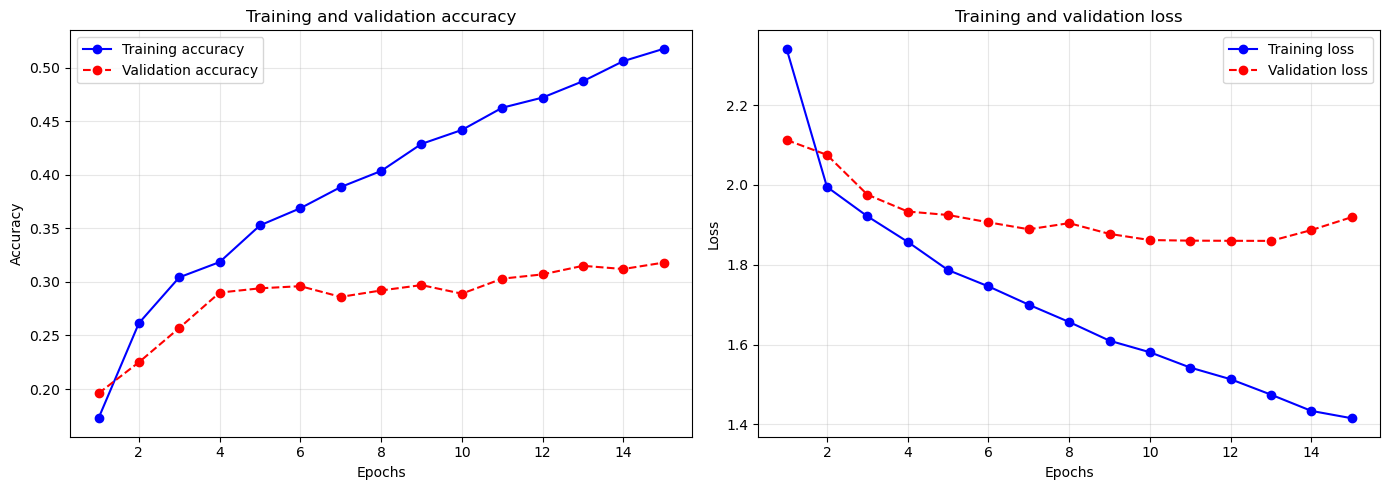

In [9]:
hist_vanilla, loss_vanilla, acc_vanilla, prec_vanilla, rec_vanilla, f1_vanilla = entrenar(
    modelo_base,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_vanilla)

Con estos resultados, vemos que hay un claro **sobreajuste**. Las métricas de entrenamiento mejoran constantemente: la accuracy sube hasta 50.6% y el loss baja hasta 1.4 a lo largo de los 15 epochs. Sin embargo, las métricas de validación se estancan alrededor del 31% en accuracy y 1.9 en loss. 

Esta separación se ve muy bien en la gráfica, e indica que el modelo está memorizando los datos de entrenamiento en lugar de aprender patrones que generalicen bien a datos nuevos. 

Los resultados en test lo confirman: 
- El **accuracy de 34.%** indica que el modelo acierta alrededor de 1 de cada 3 imágenes (aunque en un problema de 10 clases, predecir completamente al azar daría un 10% de aciertos, por lo que el modelo sí ha aprendido algo).
- El **recall de 18.7%** significa que de todos los aviones reales en el dataset, solo detecta correctamente más o menos unos 2 de cada 10; lo mismo ocurre para gatos, perros y el resto de clases. Es decir, **el modelo es muy conservador** y prefiere no clasificar muchos casos antes que arriesgarse a equivocarse.
- La**precision de 53.56%** nos dice que cuando el modelo predice algo acierta aproximadamente la mitad de las veces.
- Esta combinación de precision y recall resulta en un **F1-score de 0.32**, confirmando que el modelo tiene un rendimiento malo.
- El **loss de 1.84** en test está muy por encima del loss de entrenamiento (1.4) que obtivimos en el último epoch, otra evidencia del sobreajuste (un modelo que generaliza bien debería tener resultados similares en entrenamiento y test).

#### Aplicación de técnicas de regularización

A partir del modelo base, hemos probado 4 técnicas de regularización para reducir el overfitting y mejorar la capacidad de generalización de la red:

- **Dropout:** apaga aleatoriamente un porcentaje de neuronas durante el entrenamiento para que la red no dependa demasiado de unas pocas neuronas específicas.
- **EarlyStopping:** detiene el entrenamiento cuando el rendimiento en validación deja de mejorar, evitando sobreentrenar.
- **Regularización L1:** penaliza pesos grandes y tiende a eliminar los menos importantes (los pone a cero).
- **Regularización L2:** penaliza pesos grandes pero de forma más suave, manteniéndolos pequeños sin eliminarlos.

Hemos probado también otras técnicas como **Batch Normalization**, pero estas cuatro fueron las que mejor nos funcionaron. Cada técnica ataca el problema desde un ángulo diferente, permitiéndonos comparar cuál funciona mejor para nuestro caso, e incluso combinarlas.

#### 3.2. Modelo 2 - Dropout

In [10]:
modelo_dropout = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),  
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15), 
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
],
    name= "Dropout")

modelo_dropout.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy', 
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),  
    metrics.F1Score(name='f1_score', average='macro')
])

modelo_dropout.summary()

Model: "Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Hemos añadido **Dropout** después de las capas más grandes para reducir el overfitting:

- **Dropout 0.1**: (10%) después de la capa de **256 neuronas**. 
    - Necesita captar toda la información básica posible, por eso usamos dropout bajo.
- **Dropout 0.15**: (15%) después de la capa de **128 neuronas**. 
    - Trabaja con características ya procesadas donde hay más redundancia, así que lo subimos un poco para evitar que memorice.

El resto de la arquitectura es la misma que el modelo vanilla. Hemos añadido **más epochs (25)** porque observamos que el modelo seguía aprendiendo al acabar los 15 que teníamos configurados por defecto.

**Por qué estos valores:** Usamos tasas bajas de dropout porque tras experimentar con valores más altos (0.3-0.5), observamos que esto empeoraba los resultados de test con respecto al modelo vanilla. Eliminaban información importante y el modelo aprendía peor, ya que tampoco tenemos una red muy grande. Otras configuraciones que probamos fueron con más tasa de dropout en la primera capa que en la segunda, pero finalmente esta fue la que nos dio mejores resultados por los motivos explicados arriba.

**Por qué en esas posiciones:** tras probar con dropout en todas las capas, solo en la primera, etc., el mejor resultado lo hemos obtenido sin aplicarlo a la última capa oculta (64 neuronas), ya que esta es bastante pequeña y así preservamos esa información antes de la clasificación final. Con esto lo que buscamos es reducir la brecha entre entrenamiento y validación y ganar algo de estabilidad en val_loss/val_acc sin tocar la capacidad del modelo.

Cabe mencionar que con un único dropout de 0.2 en la segunda capa oculta también obtuvimos resultados aceptables, aunque peores que con este modelo.

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1312 - f1_score: 0.1219 - loss: 2.6048 - precision: 0.1203 - recall: 0.0120 - val_accuracy: 0.2230 - val_f1_score: 0.1892 - val_loss: 2.0726 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1840 - f1_score: 0.1652 - loss: 2.1292 - precision: 0.4093 - recall: 0.0090 - val_accuracy: 0.2320 - val_f1_score: 0.1981 - val_loss: 2.0260 - val_precision: 0.5714 - val_recall: 0.0040
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2261 - f1_score: 0.2103 - loss: 2.0364 - precision: 0.5775 - recall: 0.0207 - val_accuracy: 0.2530 - val_f1_score: 0.2129 - val_loss: 1.9368 - val_precision: 0.5818 - val_recall: 0.0320
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2714 - f1_score: 0.2542 - loss: 1.9768 - precision: 0.5183 - recall: 0.0375 - val_accuracy: 0.2490 - val_f1_score: 0.2069 - val_loss: 1.9143 - val_precision: 0.5250 - val_rec

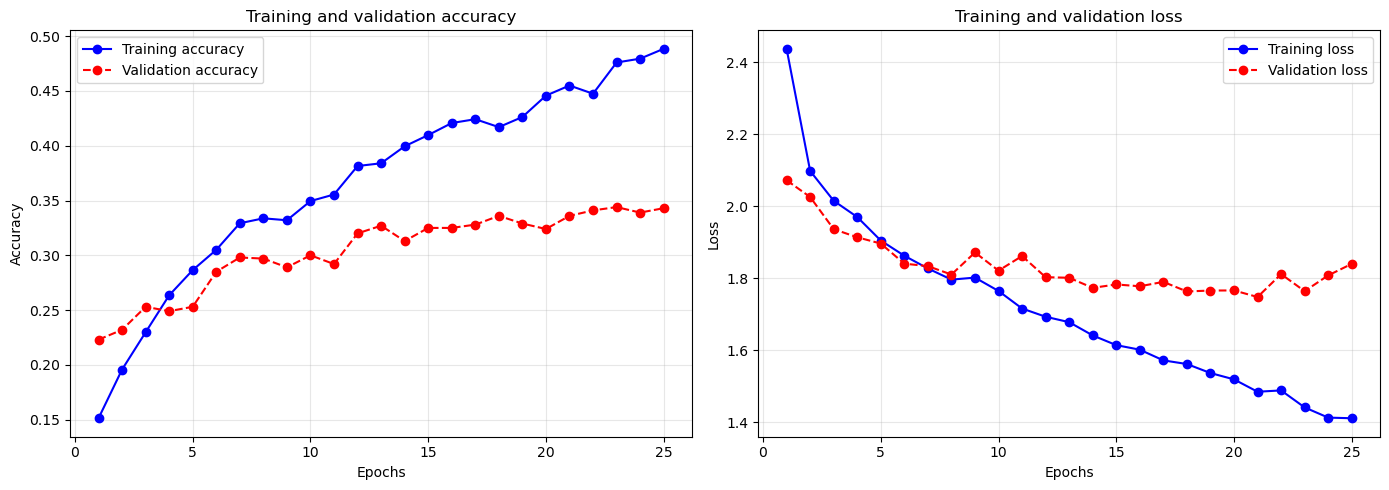

In [11]:
hist_dropout, loss_dropout, acc_dropout, prec_dropout, rec_dropout, f1_dropout = entrenar(
    modelo_dropout,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets), epochs = 25)

plot(hist_dropout)

Con estos resultados, observamos que el **Dropout ha reducido un poco el sobreajuste**, aunque no lo elimina por completo. 

Durante el entrenamiento, la *accuracy* en los datos de entrenamiento aumenta progresivamente hasta alrededor del **48%**, mientras que la de validación se mantiene estable cerca del **34%** a partir de la época 15.
El *loss* de entrenamiento desciende hasta **1.42**, pero el *loss* de validación se estabiliza en torno a **1.8**, sin mostrar mejoras claras al final del entrenamiento.
Esto indica que el modelo sigue aprendiendo patrones del conjunto de entrenamiento que no se generalizan completamente al de validación, aunque la diferencia es menor que en el modelo base.

Los resultados en test lo confirman:

* El **accuracy de 36.6%** supone una **ligera mejora respecto al modelo base (34%)**, lo que sugiere una mejor generalización.
* El **recall del 22.2%** indica que el modelo detecta algo más de casos reales que antes, aunque aún pierde muchos ejemplos positivos.
* La **precision del 54.9%** se mantiene en un nivel similar, lo que implica que las predicciones correctas siguen siendo razonablemente fiables.
* El **F1-score de 0.35** también mejora respecto al **0.32** del modelo base, reflejando un rendimiento general ligeramente superior.
* Finalmente, el **loss en test de 1.77** sigue siendo más alto que el de entrenamiento, aunque la diferencia es menor que en el modelo base, señal de una mejor regularización.

En conjunto, el Dropout consiguió **reducir parcialmente el sobreajuste** y ofrecer los mejores resultados entre todas las pruebas realizadas. Aunque los valores de validación siguen por debajo de los de entrenamiento, el modelo logra un equilibrio más estable y una ligera mejora en todas las métricas, lo que indica una **mejor capacidad de generalización** respecto al modelo base.

### 3.3. Modelo Early Stopping

In [12]:
modelo_early_stopping = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
], 
    name = "EarlyStopping"
)

modelo_early_stopping.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ])
    
modelo_early_stopping.summary()

Model: "EarlyStopping"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Aplicamos **Early Stopping** a un modelo exactamente **igual que el vanilla**, pero lo volvemos a definir. Si volviémos a entrenarlo sin redefinirlo, continuaría desde donde quedó el entrenamiento anterior, y no empezaría desde cero. 

De esta forma buscamos que el único cambio es el control del tiempo de entrenamiento.

A la hora de llamar a nuestra función de entrenamiento, configuramos Early Stopping con estos parámetros:
  - `es_monitor='val_loss'`  y `es_monitor = 'min'`: aunque el loss de entrenamiento siga bajando, el de validación mejora hasta cierto punto, luego puede empeorar (así detectamos overfitting).
  - `patience=3`: si no mejora en 3 épocas seguidas, paramos. En este caso donde lo aplicamos directamente sobre el modelo vanilla, con más paciencia el modelo es demasiado permisivo y acaba sobreajustándose igual, pero con menos paciencia se detiene antes de tiempo.
  - `restore_best_weights=True`: nos quedamos con los pesos de la mejor época.

Con esto lo que queremos es evitar que el modelo siga entrenando cuando ya no mejora en validación y **quedarnos con el punto óptimo** antes de que aparezca mucho sobreajuste.

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1372 - f1_score: 0.0972 - loss: 2.7580 - precision: 0.0977 - recall: 0.0177 - val_accuracy: 0.1810 - val_f1_score: 0.1289 - val_loss: 2.1419 - val_precision: 0.4627 - val_recall: 0.0310
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2634 - f1_score: 0.2438 - loss: 2.0401 - precision: 0.6051 - recall: 0.0223 - val_accuracy: 0.2020 - val_f1_score: 0.1632 - val_loss: 2.1174 - val_precision: 0.3533 - val_recall: 0.0650
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2868 - f1_score: 0.2735 - loss: 1.9634 - precision: 0.6028 - recall: 0.0660 - val_accuracy: 0.2320 - val_f1_score: 0.1986 - val_loss: 2.0442 - val_precision: 0.4352 - val_recall: 0.0840
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3047 - f1_score: 0.2858 - loss: 1.9058 - precision: 0.6395 - recall: 0.0923 - val_accuracy: 0.2890 - val_f1_score: 0.2619 - val_loss: 1.9194 - val_precision: 0.5263 - val_recall: 0.0

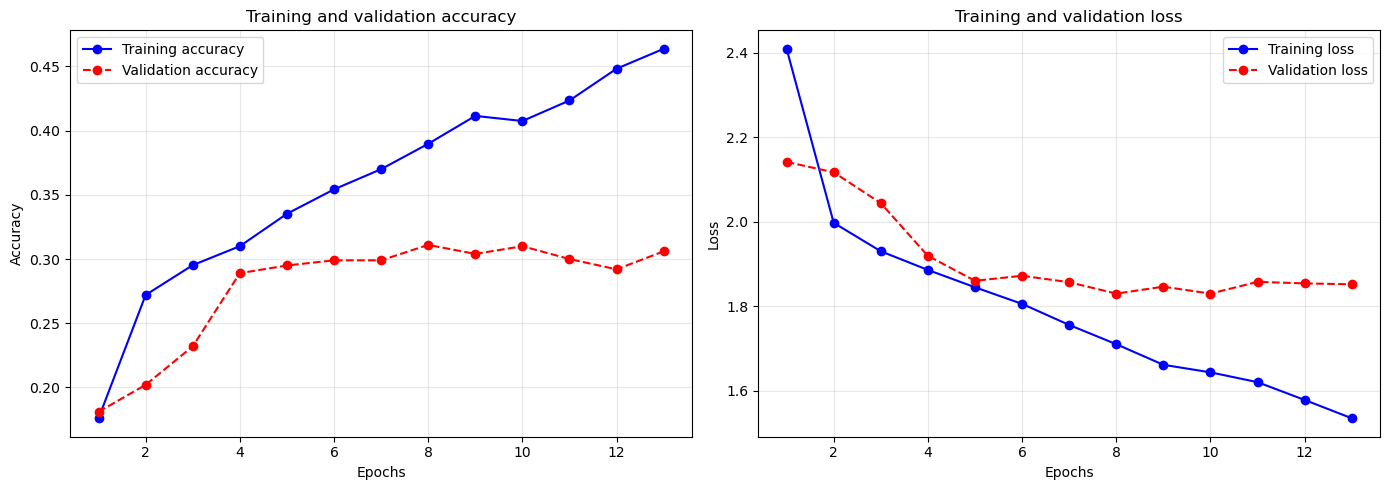

In [13]:
hist_early_stopping, loss_early_stopping, acc_early_stopping, prec_early_stopping, rec_early_stopping, f1_early_stoppingt = entrenar(
    modelo_early_stopping,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets),
    epochs=50,
    use_early_stopping=True,
    es_patience=3
)

plot(hist_early_stopping)

Con estos resultados, se observa que el uso de **Early Stopping** ha permitido **controlar el sobreajuste de manera más efectiva**, deteniendo el entrenamiento antes de que el modelo comenzase a degradar su rendimiento en validación.
El entrenamiento se detuvo automáticamente en la **época 13**, momento en el que la *validation loss* alcanzó su mejor valor.
En las gráficas se observa que la *accuracy* de entrenamiento aumenta de forma constante hasta el **44%**, mientras que la de validación se mantiene más estable alrededor del **30%**, con menor separación entre ambas curvas que en el modelo base.
De igual forma, el *loss de validación* se estabiliza a partir de la época 10, mientras que el *loss de entrenamiento* sigue disminuyendo un poco. Aun así, la diferencia entre ambos se mantiene moderada, lo que indica que el modelo ha logrado un aprendizaje más equilibrado y con menor tendencia al sobreajuste.

En el conjunto de test, los resultados son los siguientes:

* El **accuracy de 33.4%** es similar al del modelo base, lo que indica que la generalización se mantiene, aunque el entrenamiento fue más controlado.
* La **precision de 61.1%** es más alta que vanilla, lo que significa que, cuando el modelo realiza una predicción, **acierta en más de la mitad de los casos**.
* El **recall de 12.5%** sigue siendo bajo, indicando que el modelo tiende a no detectar muchos ejemplos positivos.
* El **F1-score de 0.32** es comparable al de los modelos anteriores, mostrando un equilibrio similar entre precisión y capacidad de detección
* El **loss en test (1.80)** es muy próximo al de validación, lo que confirma que el modelo ha **dejado de entrenar justo antes de sobreajustarse**.

En resumen, el **Early Stopping ha mejorado la estabilidad del entrenamiento y reducido el sobreajuste**, evitando que el modelo memorice los datos de entrenamiento y manteniendo un rendimiento equilibrado. 

#### 3.3. Modelo 3 - Regularización L1

In [14]:
modelo_L1 = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(1.6e-4)),  
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(8e-5)),    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(3.7e-5)),   
    layers.Dense(num_clases, activation='softmax')
],
    name="RegularizacionL1"
)

modelo_L1.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ])

modelo_L1.summary()

Model: "RegularizacionL1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)


Aplicamos **regularización L1 (Lasso) suave** para penalizar pesos grandes sin ser demasiado agresivos:

- **Capa 256**: L1=1.6e-4 (penalización más alta)
- **Capa 128**: L1=8e-5 (penalización media)
- **Capa 64**: L1=3.7e-5 (penalización más baja)

Usamos valores bajos porque penalizaciones más fuertes eliminaban demasiadas conexiones importantes, lo que frenaba el aprendizaje y empeoraban mucho el modelo. La estrategia es aplicar más **regularización más fuerte al principio y más suave al final** porque las primeras capas tienen más parámetros y tienden a sobreajustar más.  Con esto lo que buscamos es simplificar la red (pesos pequeños/cero), bajar el sobreajuste y estabilizar la validación manteniendo una accuracy razonable.

Estos valores específicos los obtuvimos **tras experimentar**.

Además, configuramos **más epochs (30)** ya que con esta regularización el modelo aprende mucho más lento, y con los 15 epochs por defecto se detenía demasiado pronto y açun seguía aprendiendo.


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1300 - f1_score: 0.1151 - loss: 10.6625 - precision: 0.1535 - recall: 0.0232 - val_accuracy: 0.2180 - val_f1_score: 0.1840 - val_loss: 8.2849 - val_precision: 0.3562 - val_recall: 0.0570
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2774 - f1_score: 0.2452 - loss: 7.7124 - precision: 0.5859 - recall: 0.0577 - val_accuracy: 0.2570 - val_f1_score: 0.2007 - val_loss: 6.6572 - val_precision: 0.4352 - val_recall: 0.0840
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3002 - f1_score: 0.2795 - loss: 6.3329 - precision: 0.5932 - recall: 0.0874 - val_accuracy: 0.2560 - val_f1_score: 0.2029 - val_loss: 5.8929 - val_precision: 0.3364 - val_recall: 0.0740
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3274 - f1_score: 0.3104 - loss: 5.5682 - precision: 0.5821 - recall: 0.0975 - val_accuracy: 0.2910 - val_f1_score: 0.2714 - val_loss: 5.1638 - val_precision: 0.5600 - val_recall: 0.

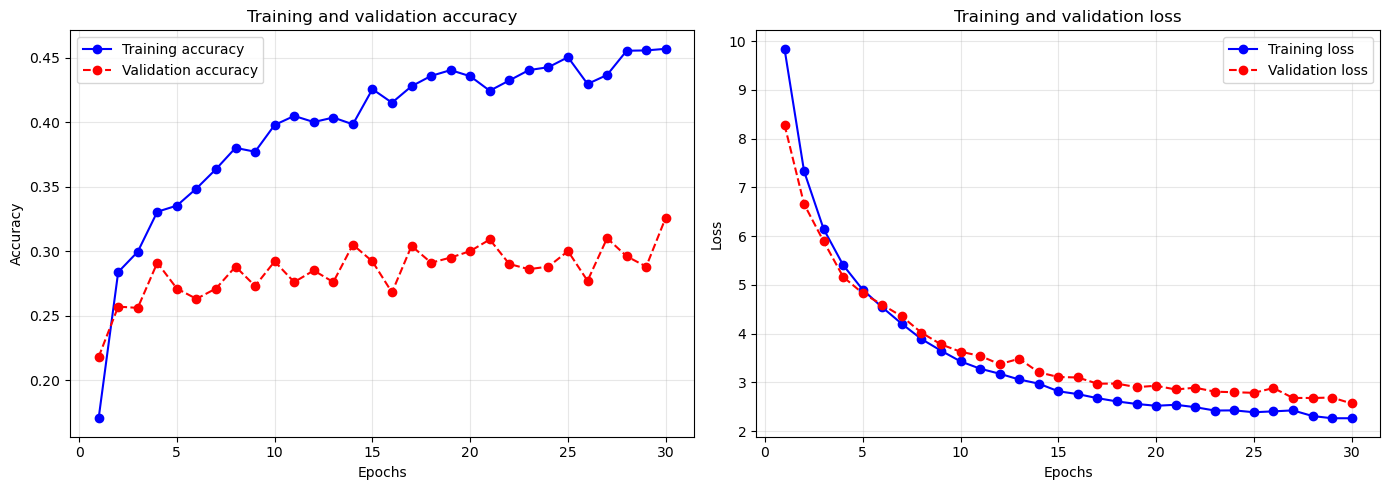

In [15]:
hist_L1, loss_L1, acc_L1, prec_L1, rec_L1, f1_L1 = entrenar(
    modelo_L1,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets), epochs = 30)

plot(hist_L1)

#### 3.4. Modelo 4 - Regularización L2

In [16]:
modelo_L2 = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dense(num_clases, activation='softmax')
],
    name="RegularizacionL2"
)

modelo_L2.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', # porcentaje total de aciertos
        metrics.Precision(name='precision'),# mide falsos positivos
        metrics.Recall(name='recall'),  # mide falsos negativos
        metrics.F1Score(name='f1_score', average='macro')  # media F1 por clase
        ])

modelo_L2.summary()

Model: "RegularizacionL2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)


Aplicamos **regularización L2 (Ridge)** en todas las capas densas con un valor de 0.005.
- **Por qué L2:** castiga los pesos grandes, haciendo que la red aprenda patrones más suaves y generales.
- **Por qué ese valor:**
  - Es una intensidad **media**, suficiente para penalizar sin impedir que la red aprenda.
  - Experimentamos, entre otros, con valores típicos como 0.01, que era demasiado fuerte y nos daba un modelo con rendimiento mucho peor que el vanilla, y 0.001, que no penalizaba lo suficiente. Al final 0.005 dio buen equilibrio.
- **Por qué en todas las capas:** así controlamos el tamaño de los pesos a lo largo de toda la red, ya que, a diferencia de L1, L2 no elimina pesos sino que los mantiene pequeños y distribuidos.

Con esto lo que buscamos es disminuir la diferencia entre entrenamiento y validación y evitar que la red memorice los datos y se reduzca la distancia entre resultados en entrenamiento y validación, manteniendo además un buen test.

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1151 - f1_score: 0.0983 - loss: 6.6512 - precision: 0.1078 - recall: 0.0231 - val_accuracy: 0.1800 - val_f1_score: 0.1136 - val_loss: 5.1334 - val_precision: 0.5102 - val_recall: 0.0250
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2593 - f1_score: 0.2153 - loss: 4.8944 - precision: 0.5790 - recall: 0.0151 - val_accuracy: 0.2410 - val_f1_score: 0.2004 - val_loss: 4.4719 - val_precision: 0.4659 - val_recall: 0.0410
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3035 - f1_score: 0.2741 - loss: 4.2970 - precision: 0.6846 - recall: 0.0554 - val_accuracy: 0.2630 - val_f1_score: 0.2415 - val_loss: 4.0853 - val_precision: 0.4887 - val_recall: 0.0650
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3398 - f1_score: 0.3114 - loss: 3.9080 - precision: 0.6819 - recall: 0.0770 - val_accuracy: 0.2820 - val_f1_score: 0.2571 - val_loss: 3.7880 - val_precision: 0.5255 - val_recall: 0.0

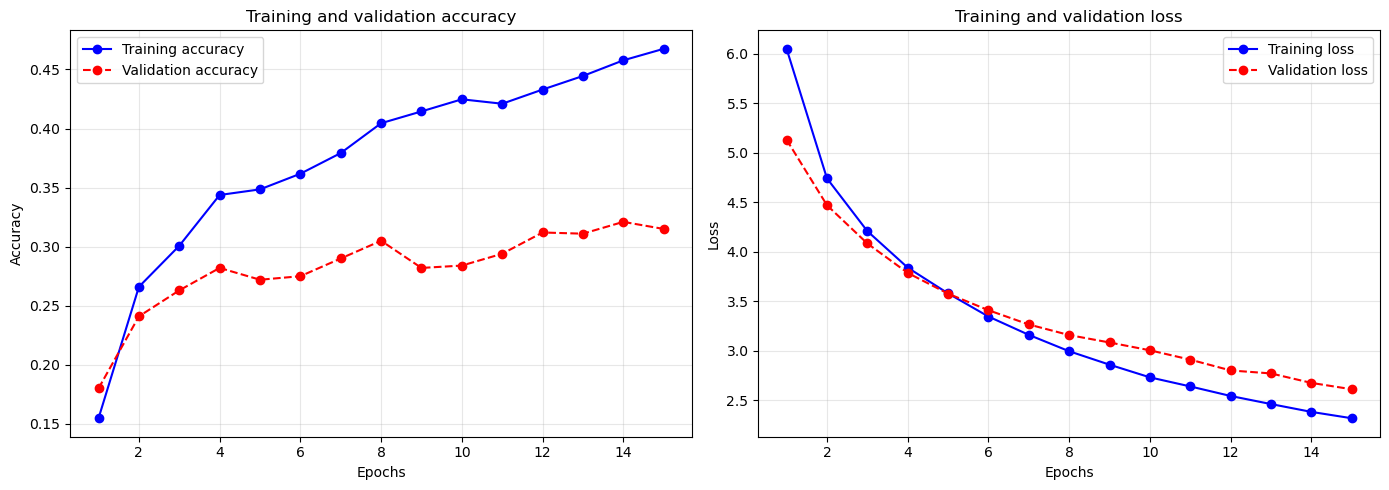

In [17]:
hist_L2, loss_L2, acc_L2, prec_L2, rec_L2, f1_L2 = entrenar(
    modelo_L2,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_L2)

#### 3.5 Modelo 5 - Híbrido

In [18]:
modelo_hibrido = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6)),
    layers.Dropout(0.08), 
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6)),
    layers.Dropout(0.12),  
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=5e-7, l2=5e-7)),
    layers.Dense(num_clases, activation='softmax')
],
    name="Hibrido")

modelo_hibrido.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ])

modelo_hibrido.summary()

Model: "Hibrido"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Hemos combinado distintas regularizaciones que hemos probado en este **modelo híbrido**:

**Regularización L1+L2 conjunta:**
- Capas 256 y 128: L1=1e-6, L2=1e-6 (muy suaves)
- Capa 64: L1=5e-7, L2=5e-7 (todavía más suaves)

Usamos valores **muy bajos** (mucho menores que cuando los aplicábamos por separado) porque estamos combinando múltiples técnicas. Con valores más altos la red estaba sobreregularizada y perdía capacidad de aprendizaje, lo que nos daba resultados mucho peores que incluso el propio modelo vanilla.

**Dropout progresivo:**
- 0.08 (8%) después de capa 256
- 0.12 (12%) después de capa 128

Son valores un poco más bajos que en el modelo de solo Dropout porque ya tenemos regularización L1+L2 trabajando. **Dropout fue la técnica que mejores resultados nos dio de forma individual, por eso quisimos mantenerla.**

**Early Stopping ajustado:**
- **40 epochs** (más que antes) con **paciencia de 5**. De esta forma le damos margen suficiente para seguir mejorando en fases si se estanca en unos pocos epochs, pero lo detenemos si realmente ha dejado de mejorar.
- Monitorizamos **val_accuracy** en lugar de val_loss porque tras experimentar con ambos, accuracy nos dio un mejor modelo.

Probamos varias combinaciones: L1+Dropout, L2+Dropout, ambas con y sin Early Stopping, el modelo por el que nos hemos decidido pero sin Early Stopping... con distintos valores para la regularización. Al final, muchas configuraciones empeoraban los resultados del modelo con solo Dropout (el mejor hasta este momento) o incluso del modelo vanilla. Este híbrido es la mejor combinación que encontramos, balanceando las tres técnicas sin sobre-regularizar.

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1317 - f1_score: 0.1263 - loss: 2.5456 - precision: 0.2277 - recall: 0.0080 - val_accuracy: 0.2160 - val_f1_score: 0.1623 - val_loss: 2.1931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1848 - f1_score: 0.1745 - loss: 2.2428 - precision: 0.2673 - recall: 0.0034 - val_accuracy: 0.2270 - val_f1_score: 0.1773 - val_loss: 2.1109 - val_precision: 0.6875 - val_recall: 0.0110
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2487 - f1_score: 0.2334 - loss: 2.0988 - precision: 0.5844 - recall: 0.0326 - val_accuracy: 0.2640 - val_f1_score: 0.2420 - val_loss: 2.0086 - val_precision: 0.6047 - val_recall: 0.0260
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2647 - f1_score: 0.2559 - loss: 2.0241 - precision: 0.6008 - recall: 0.0466 - val_accuracy: 0.2460 - val_f1_score: 0.2071 - val_loss: 2.0294 - val_precision: 0.6522 - val_rec

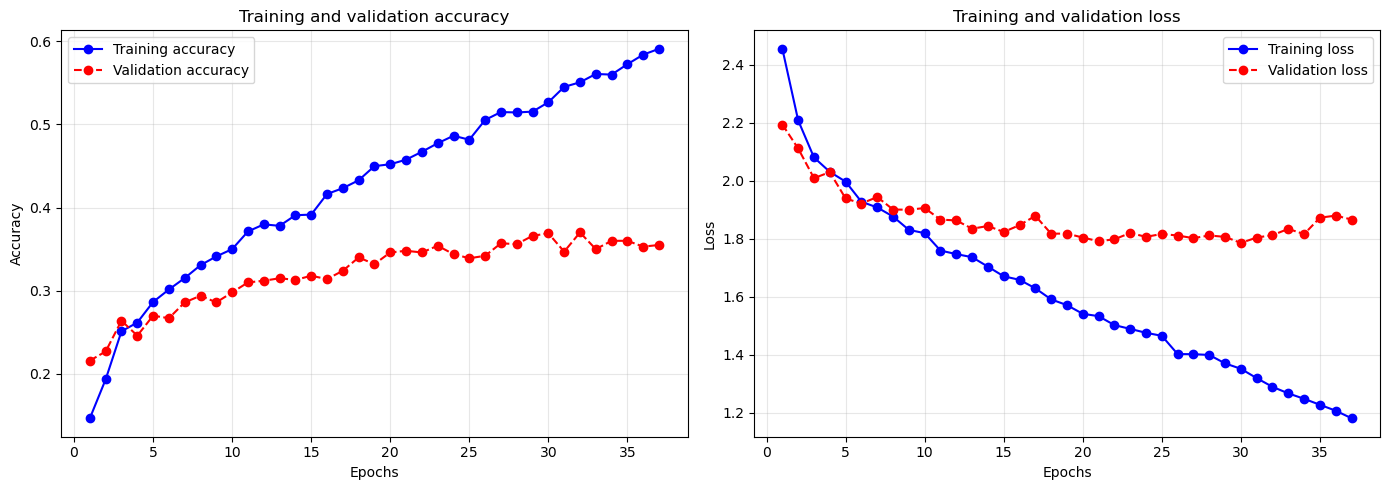

In [19]:
hist_h, loss_h, acc_h, prec_h, rec_h, f1_h = entrenar(
    modelo_hibrido,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets),
    epochs=40, use_early_stopping=True, es_patience=5 , es_mode="max", es_monitor="val_accuracy")

plot(hist_h)

### 4. Comparación y resumen de resultados

In [20]:
import pandas as pd

# Creamos la tabla con los resultados obtenidos
# (sustituye los valores entre corchetes por tus variables reales si cambian los nombres)

results = pd.DataFrame({
    "Modelo": ["Vanilla","Con Dropout","Con Early Stopping", "Con L1","Con L2 ","Híbrido"],
    "Accuracy": [acc_vanilla * 100,acc_dropout * 100, acc_early_stopping*100, acc_L1 * 100,acc_L2 * 100,acc_h * 100],
    "Precision": [prec_vanilla,prec_dropout,prec_early_stopping, prec_L1,rec_L2,prec_h],
    "Recall": [rec_vanilla,rec_dropout,rec_early_stopping,rec_L1,rec_L2,rec_h],
    "F1-Score": [f1_vanilla,f1_dropout,f1_early_stoppingt,f1_L1,f1_L2,f1_h],
    "Loss": [loss_vanilla,loss_dropout,loss_early_stopping,loss_L1,loss_L2,loss_h]
})

results = results.round({"Accuracy": 3,"Precision": 3,"Recall": 3,"F1-Score": 3})

# Mostramos la tabla ordenada por Accuracy descendente
results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

,Modelo,Accuracy,Precision,Recall,F1-Score,Loss
0,Híbrido,38.875,0.579,0.236,0.379,1.765028
1,Con Dropout,36.625,0.549,0.222,0.345,1.770928
2,Con L1,35.600,0.612,0.166,0.339,2.510766
3,Vanilla,34.850,0.536,0.187,0.324,1.841465
4,Con L2,34.850,0.159,0.159,0.333,2.569807
5,Con Early Stopping,33.375,0.611,0.126,0.324,1.805835


*NOTA*: **accuracy** se muestra como porcentaje (%).

Los modelos están ordenados de mayor a menor accuracy.

### 6. Conclusión

La red neuronal base aprende rápido y obtiene una precisión aceptable en entrenamiento, pero empieza a sobreajustar. Esto se ve porque la accuracy de entrenamiento sigue subiendo mientras que la accuracy de validación deja de mejorar e incluso baja ligeramente. Eso significa que el modelo se está adaptando demasiado a las imágenes concretas del set de entrenamiento y no generaliza tan bien a imágenes nuevas.

Cuando añadimos regularización (L2 y Dropout) el entrenamiento es más lento y la accuracy de entrenamiento es un poco más baja, pero la accuracy de validación es más estable y en general más cercana a la de entrenamiento. Esto indica que el modelo es menos dependiente de detalles concretos del conjunto de entrenamiento. En el conjunto de test, que es el que no usamos nunca para ajustar nada, el modelo regularizado mejora ligeramente el resultado respecto al modelo base. Esto sugiere que la regularización ayuda a la red a generalizar mejor.

Como desventaja, el modelo regularizado tarda un poco más en converger y necesita más épocas para exprimir su potencial, porque al apagar neuronas (Dropout) y penalizar pesos grandes (L2) le cuesta un poco más “memorizar” patrones. Aun así, para este problema de clasificación de imágenes, es preferible un modelo que generaliza mejor aunque entrene un poco más lento.